In [20]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
#import scienceplots
import math
import os
import bisect
import pickle
import glob
import CDOconcat


# plt.rcParams.update({"text.usetex": False,
#                      "text.latex.preamble" : r"\usepackage{amsmath} \usepackage{amssymb}",
#                      "font.family" : "serif",
#                      "font.serif" : "STIXGeneral", 
#                      "mathtext.fontset" : "stix",
#                      "xtick.direction" : "in", 
#                      "xtick.major.size" : 5,
#                      "xtick.major.width" : 0.7,
#                      "xtick.minor.size" : 2.5,
#                      "xtick.minor.width" : 0.5,
#                      "xtick.minor.visible" : True,
#                      "xtick.top" : False,
#                      "ytick.direction" : "in",
#                      "ytick.major.size" : 5,
#                      "ytick.major.width" : 0.7,
#                      "ytick.minor.size" : 2.5,
#                      "ytick.minor.width" : 0.5,
#                      "ytick.minor.visible" : True,
#                      "ytick.right" : True,
#                      "legend.frameon" : False,
plt.rcParams.update({'font.size': 16, 
                     "figure.dpi" : 150,
                     'lines.linewidth': 1.5,
                     'figure.constrained_layout.use': True,
                     'image.cmap': 'inferno'})
plt.rcParams['image.cmap'] = 'inferno'
# matplotlib.rcParams['axes.prop_cycle'] = (cycler('color', ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']) 
#                                           + cycler(ls=['-', '--', ':', '-.', (5, (10, 3)), (0, (3, 5, 1, 5))]))
# plt.style.use('science')  # ['science', 'ieee']
# %matplotlib widget


def basic_1D(figsize=[6,4], ydata=[None], xdata=None, ylabel=None, xlabel=None, title=None,
             yscale="linear", xscale="linear", drawstyle="default", colorlist=None, labels=None, linestyles=None,
             ymin=None, ymax=None, xmin=None, xmax=None, savename=None, plotfoldername=None, grid=True):
    
    fig = plt.figure(figsize=figsize)
    kwargs = {"drawstyle": drawstyle}

    if colorlist is not None:
        kwargs.update({"c": colorlist})

    if labels is not None:
        kwargs.update({"label": labels})

    for data in enumerate(ydata):
        plt.plot(xdata, data, **kwargs)

    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_xscale(xscale)
    axes.set_ylim([ymin, ymax])
    axes.set_xlim([xmin, xmax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    if grid: axes.grid()
    if title is not None: plt.title(title)
    
    if savename:
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    else:
        plt.show()


def basic_2D(data, figsize=[6,5], xgrid=None, ygrid=None, savename=None, 
             title=None, cbarlabel=None, plotfoldername=None, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, xlabel=None, ylabel=None, yscale="linear",
             datamin=None, datamax=None, logdiff=None, levels=None, cmap=None):

    if data.max() < 0 and datamax is None:
        print("Warning! Datamax < 0, switching to symlog")
        normalization = "symlog"
    
    data[data > 1e308] = 0
    data[data == float('+inf')] = 0
    
    if datamax is None:
        datamax = data.max()
    
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    if cmap is None:
        cmap = plt.colormaps['inferno']
        
    fig = plt.figure(figsize=figsize)
    axes = plt.subplot(1, 1, 1)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        levels2 = np.linspace(datamin, datamax, levels)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels2, cmap=cmap, vmin=datamin, vmax=datamax)
        cbar = plt.colorbar(plot)
    elif normalization == "symlog":
        norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'], vmax=datamax, vmin=-datamax)
        cbar = plt.colorbar()

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    axes.set_ylim(ymin, ymax)
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.set_title(title)
    axes.set_yscale(yscale)
    
    if savename:
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    

def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

    
def newest_output(path):
    list2 = glob.glob(path + 'output_??_.h5')
    if len(list2) > 0:
        return max( glob.glob(path + 'output_??_.h5'))
    else:
        return max( glob.glob(path + 'output_?_.h5'))


def calculate_index_array(timegrid, array):
    indices = np.zeros(len(array), dtype=np.intc)
    for i, j in enumerate(array):
        indices[i] = int(bisect.bisect_left(timegrid, j))
        
    return indices



TDK/
    2018_0Ar_0rec/
    2018_0Ar_6e24rec/
    2018_Ar_0rec/
    2018_lowres_diff30/
    2018_lowres_diff1000/
    ref_VDE_8ms_10cm_6e24rec_diff1000/
    VDE_0.1Ar/
    VDE_1cm/
    VDE_1ms/
    VDE_2e24rec/
    VDE_6e23rec/
    VDE_20ms/
    VDE_diff330/
    VDE_diff3300/
VDE/
    lessCompton/ - gamma flux 1e10 - original 1e18
    lessCompton2/ - gamma flux 1e15
    kin_ava/ - pCutAvalanche - 2.5
    kin_ava2/ - pCutAvalanche - 0.01

In [167]:
parentfolder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/"
folder = parentfolder + "TDK/VDE_1ms/"
#folder = parentfolder + "VDE/kin_ava/"
plt.close('all')

In [168]:
# read data
fnames = []
try:
    newest = newest_output(folder)
    print(newest)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
# print(fnames)
concat = CDOconcat.CustomConcat(fnames)
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
concat.info()


C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_1ms\output_13_.h5
Simulation time from 0.0 ms to 150.001 ms
Minor radius: [2.431159] m
Number of radial grid cells: 20
Radial step (dr): 0.12155795 m
Hottailgrid enabled: True
Resolution: (100, 1)
Runawaygrid enabled: True
Resolution: (180, 15)


In [119]:
# pickle.dump(concat, open(folder + "CDO" + endtime, "wb"))

In [120]:
# concat = pickle.load(open(folder + "CDO50", "rb"))

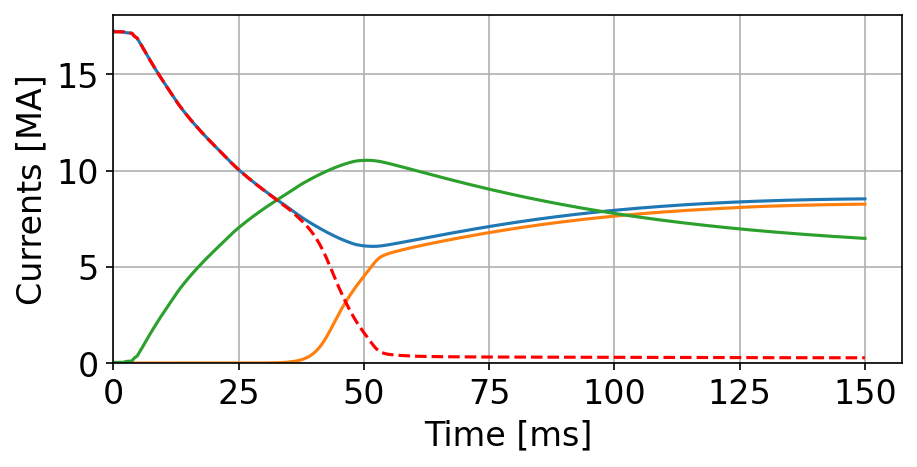

In [169]:
# Áramok figsize=(6, 5)
fig = plt.figure(figsize=(6, 3))
plt.subplot(1, 1, 1)  # rows, columns, index

plt.plot(concat.timegrid_ms, concat.I_p / 1e6, label=r"$I_{\mathrm{p}}$")
plt.plot(concat.timegrid_ms, (concat.I_re + concat.I_hot) / 1e6, label=r"$I_{\mathrm{RE}}$")
plt.plot(concat.timegrid_ms, concat.I_wall / 1e6, label=r"$I_{\mathrm{wall}}$")
plt.plot(concat.timegrid_ms,  concat.I_ohm / 1e6, linestyle="--", c="red", label=r"$I_{\mathrm{ohm}}$")  # linestyle="--", c="red",
# plt.plot(concat.timegrid_ms,  concat.I_hot / 1e6, label=r"$v$ or $\nu$")

plt.ylabel('Currents [MA]')
plt.xlabel('Time [ms]')
plt.tick_params('x', labelbottom=True)

plt.ylim(0, None)
plt.xlim(0, None)
# plt.legend(fontsize="small")
# plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linewidth": 1})
plt.grid(which="major")


plt.show()

In [171]:
# times list in milliseconds
# times = [1, 10, 20, 50, 100, 150, 300, 450, 600]
# times = [1, 10, 20, 50, 100, 200, 300, 400, 500]
# times = [1, 10, 100, 500, 1000, 1100, 1200, 1300, 1400]
times = [1, 5, 10, 20, 30, 50, 75, 100, 150]
# times = range(10, 100, 10)
# times2 = [50, 100, 150, 200, 300, 400, 500, 600]
# times2 = [800, 900, 1000, 1100, 1200, 1300, 1400]
times2 =[50, 70, 90, 110, 130, 150]
_R = 'Minor radius [m]'
_T = 'Time [ms]'

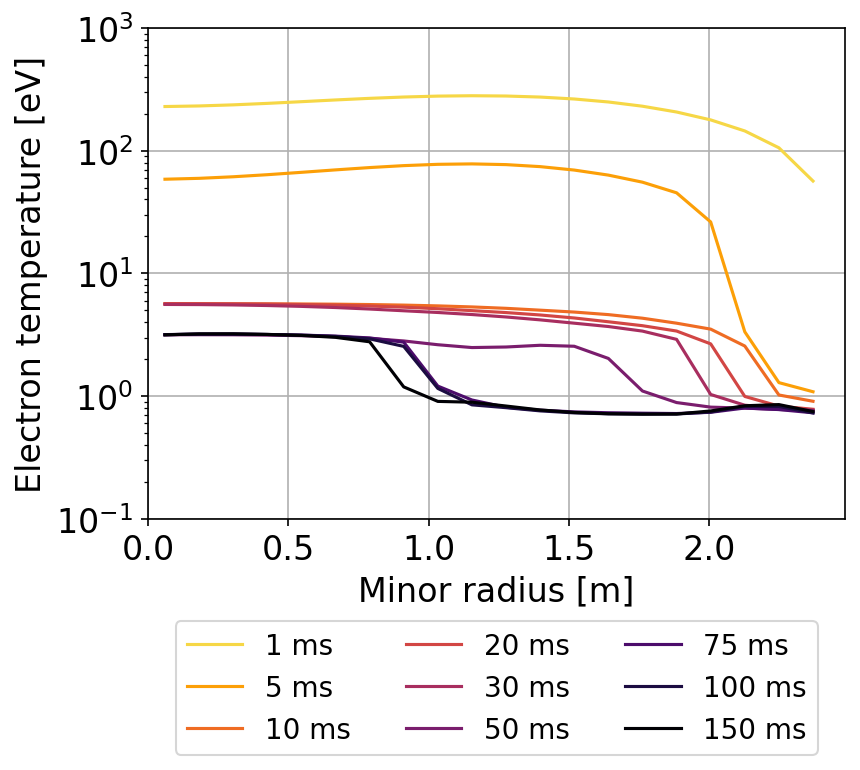

In [172]:
scale = "log" # 1D elektronhőmérséklet
indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

xdata = concat.radialgrid
ydata = concat.T_cold
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)  # rows, columns, index
# ax.set_facecolor("lightblue")
for j, i in enumerate(indices):
    plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

plt.ylabel(r'Electron temperature [eV]')
plt.xlabel(r'Minor radius [m]')
plt.tick_params('x', labelbottom=True)

plt.ylim(1e-1, 1e3)
plt.xlim(0, None)
plt.yscale(scale)
# plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
box = ax.get_position()
ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.27,
                 box.width, box.height * 0.85])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncols=3, fontsize="small")
#plt.legend()
plt.grid()
if 1:
    plt.show()
else:
    savename = "T_cold_LOG_"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

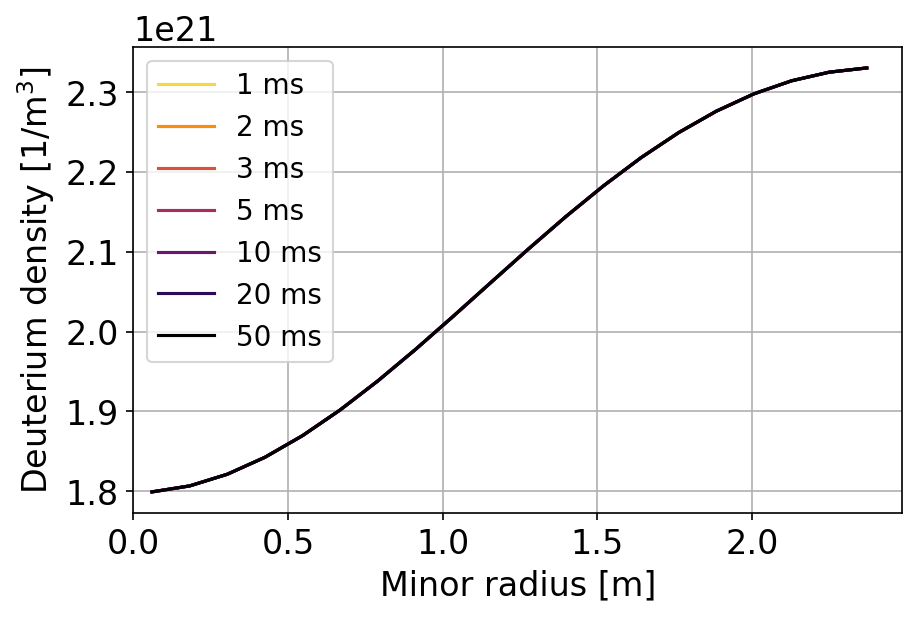

In [173]:
deuttimes = [1, 2, 3, 5, 10, 20, 50]  # Teljes deut sűrűség 1D line
indices = calculate_index_array(timegrid=concat.timegrid_ms, array=deuttimes)
# indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

xdata = concat.radialgrid
ydata = concat.density_D_0 + concat.density_D_1
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)  # rows, columns, index
# ax.set_facecolor("lightblue")
for j, i in enumerate(indices):
    plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 2))+" ms", c=ccolors[j])

plt.ylabel(r'Deuterium density [1/m$^3$]')
plt.xlabel('Minor radius [m]')
plt.tick_params('x', labelbottom=True)

plt.ylim(None, None)
plt.xlim(0, None)
#plt.yscale("log")
plt.legend(fontsize="small")
plt.grid()
plt.show()

_R = 'Minor radius [m]'
_T = 'Time [ms]'

In [174]:
language = "EN"  # "HUN", "EN", "both", "HUN_notitle", "EN_notitle" or "both_notitle" 

plotfoldernames = []
if language == "both" or language == "both_notitle":
    plotfoldernames.append(folder + "plots_EN_" + endtime + "/")
else:
    plotfoldernames.append(folder + "plots_" + language + "_" + endtime + "/")
    

for plotfoldername in plotfoldernames:
    if os.path.exists(plotfoldername):
        pass
    else:
        os.mkdir(plotfoldername)

figures = True
zoomed = True
zt = 50  # zommed time will be the [0, zt] millisecond range
if (concat.I_re[-1] + concat.I_hot[-1]) > 2e5:
    distributions = True
else:
    distributions = False
    
if concat.density_Ar.size > 0: 
    argon = True 
else: 
    argon = False


In [175]:

# Deut teljes sűrűség 1D line
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=deuttimes)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.density_D_0 + concat.density_D_1
    fig = plt.figure(figsize=(6, 5))
    ax = plt.subplot(1, 1, 1)  # rows, columns, index
    # ax.set_facecolor("lightblue")
    for j, i in enumerate(indices):
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

    plt.ylabel(r'Deuterium density [1/m$^3$]')
    plt.xlabel(_R)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(None, None)
    plt.xlim(0, None)
    #plt.yscale("log")
    plt.legend(fontsize="small")
    plt.grid()
    savename = "Deut_LINE"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# T_cold LINE plot
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))
    xdata = concat.radialgrid
    ydata = concat.T_cold
    fig = plt.figure(figsize=(6, 5))
    ax = plt.subplot(1, 1, 1)  # rows, columns, index
    # ax.set_facecolor("lightblue")
    for j, i in enumerate(indices):
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

    plt.ylabel(r'Electron temperature [eV]')
    plt.xlabel(_R)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e-1, None)
    plt.xlim(0, None)
    plt.yscale("log")
    # plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    box = ax.get_position()
    ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.27,
                    box.width, box.height * 0.85])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncols=3, fontsize="small")
    #plt.legend()
    plt.grid()
    savename = "T_cold_LINE"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
# Deut sűrűségek
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0", 
             title="D density, Z=0", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.density_D_0, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1", 
             title="D density, Z=1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.density_D_1, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_total", 
             title="D density, total", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.density_D_0 + concat.density_D_1, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)
    
if zoomed:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0_zoomed", 
             title="D density, Z=0", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.density_D_0, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1_zoomed", 
             title="D density, Z=1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.density_D_1, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_total_zoomed", 
             title="D density, total", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.density_D_0 + concat.density_D_1, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17)

# 2D áramsűrűségek
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_tot", 
             title="Total current density", cbarlabel=r"log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_tot, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_re", 
             title="RE current density", cbarlabel=r"log$_{10}$(j$_{RE}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_re, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_ohm", 
             title="Ohmic current density", cbarlabel=r"log$_{10}$(j$_{ohm}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_ohm, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)

if zoomed:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_tot_zoomed", 
             title="Total current density", cbarlabel=r"log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.j_tot, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_re_zoomed", 
             title="RE current density", cbarlabel=r"log$_{10}$(j$_{RE}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.j_re, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_ohm_zoomed", 
             title="Ohmic current density", cbarlabel=r"log$_{10}$(j$_{ohm}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=zt,
             normalization="log", data=concat.j_ohm, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)

# T_cold, E_field lin, E_c,eff
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_full", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.T_cold, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_full_ylog", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymin=1e-1, ymax=None, yscale="log",
             normalization="log", data=concat.T_cold, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="E_field_lin", 
             title="Electric field", cbarlabel=r"E [V/m]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="lin", data=concat.E_field, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="log_ratio_E_to_Eceff", 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=2, levels=5, cmap=plt.colormaps['plasma'])

# currents    
if figures:
    fig = plt.figure(figsize=(6, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    plt.plot(concat.timegrid_ms, concat.I_p / 1e6, label=r"I$_p$")
    plt.plot(concat.timegrid_ms, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
    plt.plot(concat.timegrid_ms, concat.I_wall / 1e6, label=r"I$_{wall}$")
    plt.plot(concat.timegrid_ms,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")
    #plt.plot(concat.timegrid_ms,  concat.I_hot / 1e6, label=r"I$_{hot}$")

    plt.ylabel('Currents [MA]')
    plt.xlabel('Time [ms]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, 18)
    plt.xlim(0, 150)
    plt.legend()
    plt.grid()

    savename = "0currents"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

    fig = plt.figure(figsize=(6, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    plt.plot(concat.timegrid_ms, concat.I_p / 1e6, label=r"I$_p$")
    plt.plot(concat.timegrid_ms, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
    plt.plot(concat.timegrid_ms, concat.I_wall / 1e6, label=r"I$_{wall}$")
    plt.plot(concat.timegrid_ms,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")
    #plt.plot(concat.timegrid_ms,  concat.I_hot / 1e6, label=r"I$_{hot}$")

    plt.ylabel('Currents [MA]')
    plt.xlabel('Time [ms]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, 18)
    plt.xlim(0, None)
    plt.legend()
    plt.grid()

    savename = "0currents_full"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# f_re - multiple
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.95, 0, len(indices)))

    xdata = concat.re_momentumgrid

    ydata = concat.f_re_avg[:, 0]
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    
    for j, i in enumerate(indices):
        plt.plot(xdata, ydata[i], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

    plt.ylabel(r'$\langle f_{RE} \rangle$  [m$^{-3}$]')
    plt.xlabel(r'p$_{||}$ normalized to m$_e$c')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e9, 1e13)
    plt.xlim(0, 50)
    plt.xticks(ticks=range(0, 50, 5))
    plt.yscale("log")
    plt.legend(ncols=2, fontsize="small")
    plt.grid()

    savename = "f_re_zoomed"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
    for r in [0, 1, 9, 10, 18, 19]:
        ydata = concat.f_re_avg[:, r]
        fig = plt.figure(figsize=(7, 4))
        plt.subplot(1, 1, 1)  # rows, columns, index
        
        for j, i in enumerate(indices):
            plt.plot(xdata, ydata[i], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

        plt.ylabel(r'$\langle f_{RE} \rangle$  [m$^{-3}$]')
        plt.xlabel(r'p$_{||}$ normalized to m$_e$c')
        plt.tick_params('x', labelbottom=True)

        plt.ylim(1e7, 1e14)
        plt.yscale("log")
        plt.legend(ncols=2)
        plt.grid()

        savename = ("f_re_avg" + "_at_" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")

        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)

# n_re     
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.95, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.n_re
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'RE density [m$^{-3}$]')
    plt.xlabel(_R)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e14, None)
    plt.yscale("log")
    plt.legend(ncols=2, fontsize="small")
    plt.grid()

    savename = "n_RE_LINE"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# j_re   
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.95, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_re
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])
        j += 1

    plt.ylabel(r'RE current density [A/m$^{2}$]')
    plt.xlabel(_R)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend(ncols=2, fontsize="small")
    plt.grid()

    savename = "j_re_LINE"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# j_tot  
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_tot
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Total current density [A/m$^{2}$]')
    plt.xlabel(_R)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend(ncols=2, fontsize="small")
    plt.grid()

    savename = "j_tot_LINE"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# Argon ionizációfok 
if argon:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Ar_avg_Z", 
             title="Average Ar ionization", cbarlabel=r"Z$_{avg}$(Ar) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="lin", data=concat.avg_Ar_ionization, xlabel=_R, ylabel=_T,
             datamin=1, datamax=18, levels=18, cmap=plt.colormaps['plasma'])

    fig = plt.figure(figsize=[8,4])
    plt.plot(concat.timegrid_ms, concat.W_cold_sum / 1e6, color='red', zorder=4)
    plt.grid(axis='x', which='both')
    axes = plt.gca()
    axes.set_ylabel(r"E$_{thermal}$ [MJ]", c="red")
    axes.set_yscale("log")
    ax2 = axes.twinx()
    ax2.plot(concat.timegrid_ms, np.sum(concat.avg_Ar_ionization, axis=1) / len(concat.radialgrid), color="green", zorder=5)
    ax2.set_ylabel(r"Z$_{avg}$(Ar) [-]", c="green")
    ax2.grid(axis="y", which="both")
    ax2.set_ylim(0, 18)
    axes.set_xlabel(_T)
    plt.savefig(plotfoldername + "Wcold_vs_Arion" + ".png", dpi=150)
    plt.close(fig)

# keletkezési ráták
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="g_Dreicer", 
             title="Dreicer generation", cbarlabel=r"log$_{10}$($\gamma_{D}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaDreicer, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=5, levels=16, cmap=plt.colormaps['viridis'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="g_Compton", 
             title="Compton generation", cbarlabel=r"log$_{10}$($\gamma_{C}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaCompton, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['viridis'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="g_Ava", 
             title="Avalanche generation", cbarlabel=r"log$_{10}$($\gamma_{ava}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaAva * concat.n_re, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=13, levels=27, cmap=plt.colormaps['viridis'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="fre_coll", 
             title="RE collisional heating\npower density", cbarlabel=r"PD$_{coll}$ [MWm$^{-3}$]", 
             plotfoldername=plotfoldername, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, data=abs(concat.Tcold_fre_coll) / 1e6, xlabel=_R, ylabel=_T,
             datamin=None, datamax=None, logdiff=None, levels=119, cmap=plt.colormaps['plasma'])
    # LINE avg generation rates 
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    # For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaAva * concat.n_re, axis=1) / len(concat.radialgrid), label=r"$\gamma_{ava}$")
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaCompton, axis=1) / len(concat.radialgrid), label=r"$\gamma_C$")
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaTritium, axis=1) / len(concat.radialgrid), label=r"$\gamma_T$")
    plt.plot(concat.timegrid_ms, np.sum(concat.flux_to_RE, axis=1) / len(concat.radialgrid), label=r"$\gamma_{D+ht}$", c="purple")

    plt.ylabel("Radial average of RE\n" r"generation rates [s$^{-1}$m$^{-3}$]")
    plt.xlabel(_T)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(-1e19, 1e19)
    plt.yscale('symlog', linthresh=1)
    plt.xlim(0, None)
    plt.yticks(ticks=[1e18, 1e14, 1e10, 1e6, 1e2, 0, -1e2, -1e6, -1e10, -1e14, -1e18])
    plt.legend()
    plt.grid(which="both")

    savename = "genrates_LINE"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close()

    # LINE LOG avg generation rates 
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)  # rows, columns, index
    # For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaAva * concat.n_re, axis=1) / len(concat.radialgrid), label=r"$\gamma_{ava}$")
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaCompton, axis=1) / len(concat.radialgrid), label=r"$\gamma_C$")
    plt.plot(concat.timegrid_ms, np.sum(concat.gammaTritium, axis=1) / len(concat.radialgrid), label=r"$\gamma_T$")
    plt.plot(concat.timegrid_ms, np.sum(concat.flux_to_RE, axis=1) / len(concat.radialgrid), label=r"$\gamma_{D+ht}$", c="purple")

    plt.ylabel("Radial average of RE\n" r"generation rates [s$^{-1}$m$^{-3}$]")
    plt.xlabel(_T)
    plt.tick_params('x', labelbottom=True)

    plt.ylim(-1e19, 1e19)
    plt.yscale('symlog', linthresh=1)
    plt.xlim(0.1, None)
    plt.xscale("log")
    plt.yticks(ticks=[1e18, 1e14, 1e10, 1e6, 1e2, 0, -1e2, -1e6, -1e10, -1e14, -1e18])
    plt.legend()
    plt.grid(which="both")

    savename = "genrates_LOG"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close()
        
# teljesítménysűrűségek
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="W_cold", 
            title="Thermal electron energy density", cbarlabel=r"log$_{10}$(W$_{cold}$/(J/m$^3$)) [-]", 
            plotfoldername=plotfoldername, ymax=None,
            normalization="log", data=concat.W_cold, xlabel=_R, ylabel=_T,
            datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_ohm", 
            title="Ohmic heating power density", cbarlabel=r"log$_{10}$(PD$_{ohm}$/(W/m$^3$)) [-]", 
            plotfoldername=plotfoldername, ymax=None,
            normalization="log", data=-concat.Tcold_ohmic, xlabel=_R, ylabel=_T,
            datamin=None, datamax=1e9, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_rad", 
            title="Radiated power density", cbarlabel=r"log$_{10}$(PD$_{rad}$/(W/m$^3$)) [-]", 
            plotfoldername=plotfoldername, ymax=None,
            normalization="log", data=concat.Tcold_radiation, xlabel=_R, ylabel=_T,
            datamin=None, datamax=1e9, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_tr_pos", 
            title="Transported power density", cbarlabel=r"log$_{10}$(PD$_{tr}$/(W/m$^3$)) [-]", 
            plotfoldername=plotfoldername, ymax=None,
            normalization="log", data=concat.Tcold_transport, xlabel=_R, ylabel=_T,
            datamin=None, datamax=1e9, logdiff=5, levels=11)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_tr_neg", 
            title="Negative transported p. d.", cbarlabel=r"log$_{10}$(-PD$_{tr}$/(W/m$^3$)) [-]", 
            plotfoldername=plotfoldername, ymax=None, cmap=plt.colormaps['viridis'],
            normalization="log", data=-concat.Tcold_transport, xlabel=_R, ylabel=_T,
            datamin=None, datamax=1e9, logdiff=5, levels=11, linthresh=1e9)

if zoomed:
        basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="W_cold_zoomed", 
                title="Thermal electron energy density", cbarlabel=r"log$_{10}$(W$_{cold}$/(J/m$^3$)) [-]", 
                plotfoldername=plotfoldername, ymax=zt,
                normalization="log", data=concat.W_cold, xlabel=_R, ylabel=_T,
                datamin=None, datamax=None, logdiff=5, levels=16)
        basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_ohmic_zoomed", 
                title="Ohmic heating power density", cbarlabel=r"log$_{10}$(PD$_{ohm}$/(W/m$^3$)) [-]", 
                plotfoldername=plotfoldername, ymax=zt,
                normalization="log", data=-concat.Tcold_ohmic, xlabel=_R, ylabel=_T,
                datamin=None, datamax=1e9, logdiff=5, levels=16)
        basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_rad_zoomed", 
                title="Radiated power density", cbarlabel=r"log$_{10}$(PD$_{rad}$/(W/m$^3$)) [-]", 
                plotfoldername=plotfoldername, ymax=zt,
                normalization="log", data=concat.Tcold_radiation, xlabel=_R, ylabel=_T,
                datamin=None, datamax=1e9, logdiff=5, levels=16)
        basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_transport_zoomed", 
                title="Transported power density", cbarlabel=r"log$_{10}$(PD$_{tr}$/(W/m$^3$)) [-]", 
                plotfoldername=plotfoldername, ymax=zt,
                normalization="log", data=concat.Tcold_transport, xlabel=_R, ylabel=_T,
                datamin=None, datamax=1e9, logdiff=5, levels=11)
        basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_transport_neg_zoomed", 
                title="Negative transported p. d.", cbarlabel=r"log$_{10}$(-PD$_{tr}$/(W/m$^3$)) [-]", 
                plotfoldername=plotfoldername, ymax=zt, cmap=plt.colormaps['viridis'],
                normalization="log", data=-concat.Tcold_transport, xlabel=_R, ylabel=_T,
                datamin=None, datamax=1e9, logdiff=5, levels=11, linthresh=1e9)

# vs plots
if figures:
    fig = plt.figure(figsize=[6,5])
    plt.plot(concat.timegrid_ms, np.sum(concat.T_cold, axis=1) / len(concat.radialgrid), color='red', zorder=4)
    plt.grid(axis='x', which='both')
    axes = plt.gca()
    axes.set_ylabel("Radial avg of electron temp [eV]", c="red")
    axes.set_yscale("log")
    axes.set_ylim(0.1, None)
    ax2 = axes.twinx()
    ax2.plot(concat.timegrid_ms, np.sum(concat.E_field, axis=1) / len(concat.radialgrid), color="green", zorder=5)
    ax2.set_ylabel("Avg of electric field [V/m]", c="green")
    axes.grid(axis="y", which="both")
    ax2.set_ylim(0, None)
    axes.set_xlabel(_T)
    plt.savefig(plotfoldername + "Tcold_vs_Efield" + ".png", dpi=150)
    plt.close()



C:\Users\lefer\AppData\Local\Temp\ipykernel_20552\2846261936.py:125: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
